In [2]:
import os 
from pathlib import Path

In [3]:
os.chdir("../")
%pwd

'd:\\college_work\\4th year\\Sem7th\\Project\\major-project\\Code\\Heart-Disease-Classification-with-Electrocardiogram'

##  Code


In [3]:

from dataclasses import dataclass

@dataclass(frozen=True)
class DataTransformationConfig:
    root_dir: Path
    data_path: Path 
    ptbxl_csv_path: Path 
    scp_csv_path: Path 
    superclass_csv_data: Path
    freq_rate: int
    ecg_data_path: str

In [4]:
from heartDiseaseClassification.utils.common import read_yaml,create_directories
from heartDiseaseClassification.constant import *
from heartDiseaseClassification import logger

In [5]:
class ConfigurationManager:
    def __init__(
        self,
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):
        
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        
        create_directories([self.config.artifacts_root])

    def get_data_transformation_config(self) -> DataTransformationConfig:
        config = self.config.data_transformation
        params = self.params.data_transformation

        create_directories([config.root_dir])

        data_transformation_config = DataTransformationConfig(
            root_dir = config.root_dir,
            data_path = config.data_path,
            ptbxl_csv_path = config.ptbxl_csv_path,
            scp_csv_path = config.scp_csv_path,
            superclass_csv_data = config.superclass_csv_data,
            freq_rate = params.freq_rate,
            ecg_data_path = config.ecg_data_path,
        )
        
        return data_transformation_config

In [6]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import wfdb 
import ast

In [7]:
class Datatransformation:
    def __init__(self, config: DataTransformationConfig):
        self.config = config

    def load_ecg_data(self, df, freq_rate, path):
        """loadding ECG data with 100 frequency

        Args:
            df (pandas): (pbtxl_database.csv) dataframe containing location of ecg data
            freq_rate (int): frequency of ECG signal
            path (Path): root dir

        Returns:
            numpy.ndarry : ECG signal in form of numpy array
        """
        logger.info(f"loading the ecg data with freq_rate {freq_rate}")
        data = []
        if freq_rate == 100:
            # data = df['filename_lr'].apply(lambda x:wfdb.rdsamp(os.path.join(path,x)) )
            # data = [wfdb.rdsamp(os.path.join(path,f)) for f in df.filename_lr]
            for filename in df["filename_lr"]:
                try:
                    sample = wfdb.rdsamp(os.path.join(os.path.join(path, filename)))
                    data.append(sample)
                except Exception as e:
                    logger.error(f"error processing file {filename}: {e}")
        else:
            for filename in df["filename_hr"]:
                try:
                    sample = wfdb.rdsamp(os.path.join(os.path.join(path, filename)))
                    data.append(sample)
                except Exception as e:
                    logger.error(f"error processing file {filename}: {e}")
        logger.info(f"ecg data loaded!! converting to numpy.")
        data = np.array([signal for signal, meta in data])
        return data

    def load_ptbxl_csv_file(self):
        """ 
        loadding ptbxl_database.csv file
        """
        logger.info(f"loading csv file !! location {self.config.ptbxl_csv_path}")
        Y = pd.read_csv(self.config.ptbxl_csv_path, index_col="ecg_id")
        Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
        X = self.load_ecg_data(Y, self.config.freq_rate, self.config.data_path)
        np.save(self.config.ecg_data_path,X)
        logger.debug(f"The shape of ecg data is: {X.shape}")
        logger.debug(f"The shape of ptbxl file data is: {Y.shape}")

    def aggregate_diagnostic(self,dit_superclass_dict):
        tmp = []
        Y = pd.read_csv(self.config.ptbxl_csv_path)
        for key in dit_superclass_dict.keys():
            if key in Y.index:
                tmp.append(Y.loc[key].diagnostic_class)
        return list(set(tmp))

    def train_test_split(self):
        scp_statement = pd.read_csv(self.config.scp_csv_path,index_col=0)
        Y = pd.read_csv(self.config.ptbxl_csv_path)
        X = np.load(self.config.ecg_data_path)
        Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
        Y['diagnostic_superclass'] = Y.scp_codes.apply(self.aggregate_diagnostic)
        ## location all super classes total 5
        ## maksing with the length of the list =1
        mask = Y['diagnostic_superclass'].apply(lambda x:len(x) == 1)        
        Y_filterted = Y[mask]
        X_filterted = X[mask]

        Y_filterted.apply(lambda x: x[0])
        test_fold,val_fold = 10,9
        
        logger.info(f"maskng bet testing and validation set")
        # Train 
        X_train = X_filterted[np.where((Y_filterted.strat_fold != test_fold) & (Y_filterted.strat_fold != val_fold))]
        y_train = Y_filterted[((Y_filterted.strat_fold != test_fold) & (Y_filterted.strat_fold != val_fold))].diagnostic_superclass
        
        # Test
        X_test = X_filterted[np.where(Y_filterted.strat_fold == test_fold)]
        y_test = Y_filterted[(Y_filterted.strat_fold == test_fold)].diagnostic_superclass

        # Valdiation
        X_val = X_filterted[np.where((Y_filterted.strat_fold == val_fold) )]
        y_val = Y_filterted[(Y_filterted.strat_fold == val_fold)].diagnostic_superclass

        logger.info(f"sacinvg hte training testing data")
        np.save(os.path.join(self.config.root_dir,"X_train.npy"),X_train)
        np.save(os.path.join(self.config.root_dir,"X_test.npy"),X_test)
        np.save(os.path.join(self.config.root_dir,"X_val.npy"),X_val)
        np.save(os.path.join(self.config.root_dir,"y_train.npy"),y_train)
        np.save(os.path.join(self.config.root_dir,"y_test.npy"),y_test)
        np.save(os.path.join(self.config.root_dir,"y_val.npy"),y_val)

        print(f"y_train shape {y_train.shape}, X_train shape {X_train.shape}")
        print(f"y_test shape {y_test.shape}, X_test shape {X_test.shape}")
        print(f"y_val shape {y_val.shape}, X_val shape {X_val.shape}")

In [9]:
try:
    config = ConfigurationManager()
    data_transformation_config = config.get_data_transformation_config()
    data_transformation = Datatransformation(config=data_transformation_config)
    # data_transformation.load_ptbxl_csv_file()
    logger.info(f"running train test spilit")
    data_transformation.train_test_split()
except Exception as e:
    raise e

[2024-02-14 15:35:08: INFO: common: yaml files: config.yaml loadded successfully!!]
[2024-02-14 15:35:08: INFO: common: yaml files: params.yaml loadded successfully!!]
[2024-02-14 15:35:08: INFO: common: created director at : artifacts]
[2024-02-14 15:35:08: INFO: common: created director at : artifacts/data_transformation]
[2024-02-14 15:35:08: INFO: 177706181: running train test spilit]


## Regular Code


In [3]:
raw_data_path = Path("artifacts/data_ingestion/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3")
data_path  = os.path.join(os.getcwd(),raw_data_path)
data_path

'd:\\college_work\\4th year\\Sem7th\\Project\\major-project\\Code\\Heart-Disease-Classification-with-Electrocardiogram\\artifacts\\data_ingestion\\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'

In [43]:
import glob

dataset_path = "artifacts/data_ingestion/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/records100/"
base_path = "artifacts/data_ingestion/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/"

all_files = glob.glob(os.path.join(base_path, 'records100', '**'), recursive=True)

print(f"Files in {base_path}:")
for file_path in all_files:
    if os.path.isfile(file_path):
        relative_path = os.path.relpath(file_path, base_path)
        folder, filename = os.path.split(relative_path)
        print(f"{folder}/{os.path.splitext(filename)[0]}")

Files in artifacts/data_ingestion/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/:
records100\00000/00001_lr
records100\00000/00001_lr
records100\00000/00002_lr
records100\00000/00002_lr
records100\00000/00003_lr
records100\00000/00003_lr
records100\00000/00004_lr
records100\00000/00004_lr
records100\00000/00005_lr
records100\00000/00005_lr
records100\00000/00006_lr
records100\00000/00006_lr
records100\00000/00007_lr
records100\00000/00007_lr
records100\00000/00008_lr
records100\00000/00008_lr
records100\00000/00009_lr
records100\00000/00009_lr
records100\00000/00010_lr
records100\00000/00010_lr
records100\00000/00011_lr
records100\00000/00011_lr
records100\00000/00012_lr
records100\00000/00012_lr
records100\00000/00013_lr
records100\00000/00013_lr
records100\00000/00014_lr
records100\00000/00014_lr
records100\00000/00015_lr
records100\00000/00015_lr
records100\00000/00016_lr
records100\00000/00016_lr
records100\00000/00017_lr
records100\00000/00017_lr
records100\0

KeyboardInterrupt: 

In [4]:
import pandas as pd
import numpy as np
from heartDiseaseClassification import logger
import wfdb
import ast
def load_raw_data(df, sampling_rate, path):
    # if sampling_rate == 100:j
    #     data = [wfdb.rdsamp(os.path.join(path,f)) for f in df.filename_lr]
    # else:
    #     data = [wfdb.rdsamp(os.path.join(path,f)) for f in df.filename_hr]
    # data = np.array([signal for signal, meta in data])
    # return data
    data = []
    if sampling_rate == 100:
        # data = df['filename_lr'].apply(lambda x:wfdb.rdsamp(os.path.join(path,x)))
        # data = [wfdb.rdsamp(os.path.join(path,f)) for f in df.filename_lr]
        for filename in df["filename_lr"]:
            try:
                sample = wfdb.rdsamp(os.path.join(os.path.join(path, filename)))
                data.append(sample)
            except Exception as e:
                
                logger.error(f"error processing file {filename}: {e}")
    else:
        for filename in df["filename_hr"]:
            try:
                sample = wfdb.rdsamp(os.path.join(os.path.join(path, filename)))
                data.append(sample)
            except Exception as e:
                logger.error(f"error processing file {filename}: {e}")
    logger.info(f"ecg data loaded!! converting to numpy.")
    data = np.array([signal for signal, meta in data])
    return data
# path = data_path
# path = 'D:\college_work\4th year\Sem7th\Project\major-project\dataset\ecg-dataset\ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'
sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(os.path.join(data_path,'ptbxl_database.csv'), index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
# Load raw signal data
# X = load_raw_data(Y, sampling_rate, data_path)

print(Y.shape)
# print(X.shape)
# # Load scp_statements.csv for diagnostic aggregation
# agg_df = pd.read_csv(os.path.join(path,'scp_statements.csv'), index_col=0)
# agg_df = agg_df[agg_df.diagnostic == 1]

# def aggregate_diagnostic(y_dic):
#     tmp = []
#     for key in y_dic.keys():
#         if key in agg_df.index:
#             tmp.append(agg_df.loc[key].diagnostic_class)
#     return list(set(tmp))

# # Apply diagnostic superclass
# Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
# print(Y)

# # Split data into train and test
# test_fold = 10
# # Train
# X_train = X[np.where(Y.strat_fold != test_fold)]
# y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# # Test
# X_test = X[np.where(Y.strat_fold == test_fold)]
# y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass
# print(f"y_test shape {y_test.shape}, X_test shape {X_test.shape}")
# print(f"y_train shape {y_train.shape}, X_train shape {X_train.shape}")

(21799, 27)


In [5]:

import numpy as np
import pandas as pd
# np.save("../Heart-Disease-Classification-with-Electrocardiogram/artifacts/wfdb_ECG_data/data_transformation/X-numpy_ecg",X)

X = np.load("artifacts/data_transformation/wfdb_ECG_data/X-numpy_ecg.npy")
X.shape

(21799, 1000, 12)

In [6]:
agg_df = pd.read_csv(os.path.join(data_path,'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
agg_df.head(2)

,description,diagnostic,form,rhythm,diagnostic_class,diagnostic_subclass,Statement Category,SCP-ECG Statement Description,AHA code,aECG REFID,CDISC Code,DICOM Code
NDT,non-diagnostic T abnormalities,1.0,1.0,NaN,STTC,STTC,other ST-T descriptive statements,non-diagnostic T abnormalities,NaN,NaN,NaN,NaN
NST_,non-specific ST changes,1.0,1.0,NaN,STTC,NST_,Basic roots for coding ST-T changes and abnorm...,non-specific ST changes,145.0,MDC_ECG_RHY_STHILOST,NaN,NaN


In [7]:
import ast
Y = pd.read_csv(os.path.join(data_path,"ptbxl_database.csv"),index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

def aggregate_diagnostic(y_dic):
    # print(y_dic)j\
    tmp = []
    for key in y_dic.keys():
        # print(f"the key is {key}")
        if key in agg_df.index:
            
            tmp.append(agg_df.loc[key].diagnostic_class)
            # print(f"value append to the tmp {list(set(agg_df.loc[key].diagnostic_class))}")
    return list(set(tmp))

# Y['diagnostic_superclass'].loc[:5] = Y.scp_codes.apply(aggregate_diagnostic)
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)
print(Y.shape)
print(X.shape)

(21799, 28)
(21799, 1000, 12)


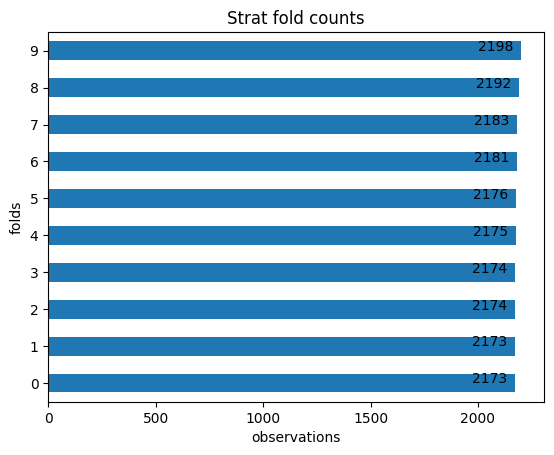

In [37]:
import matplotlib.pyplot as plt
strat_values = Y['strat_fold'].value_counts()
strat_values = strat_values.sort_values(ignore_index=True)
anot = strat_values.plot.barh()

for index, value in enumerate(strat_values):
    anot.text(value-200, index, str(value))
plt.title("Strat fold counts")
plt.xlabel("observations")
plt.ylabel("folds")
plt.show()

<Axes: >

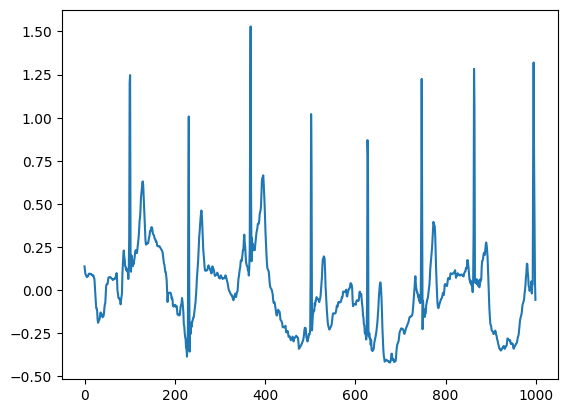

In [43]:
sample1 = X[1]
sns.lineplot(x=np.arange(sample1.shape[0]),y=sample1[:,1])

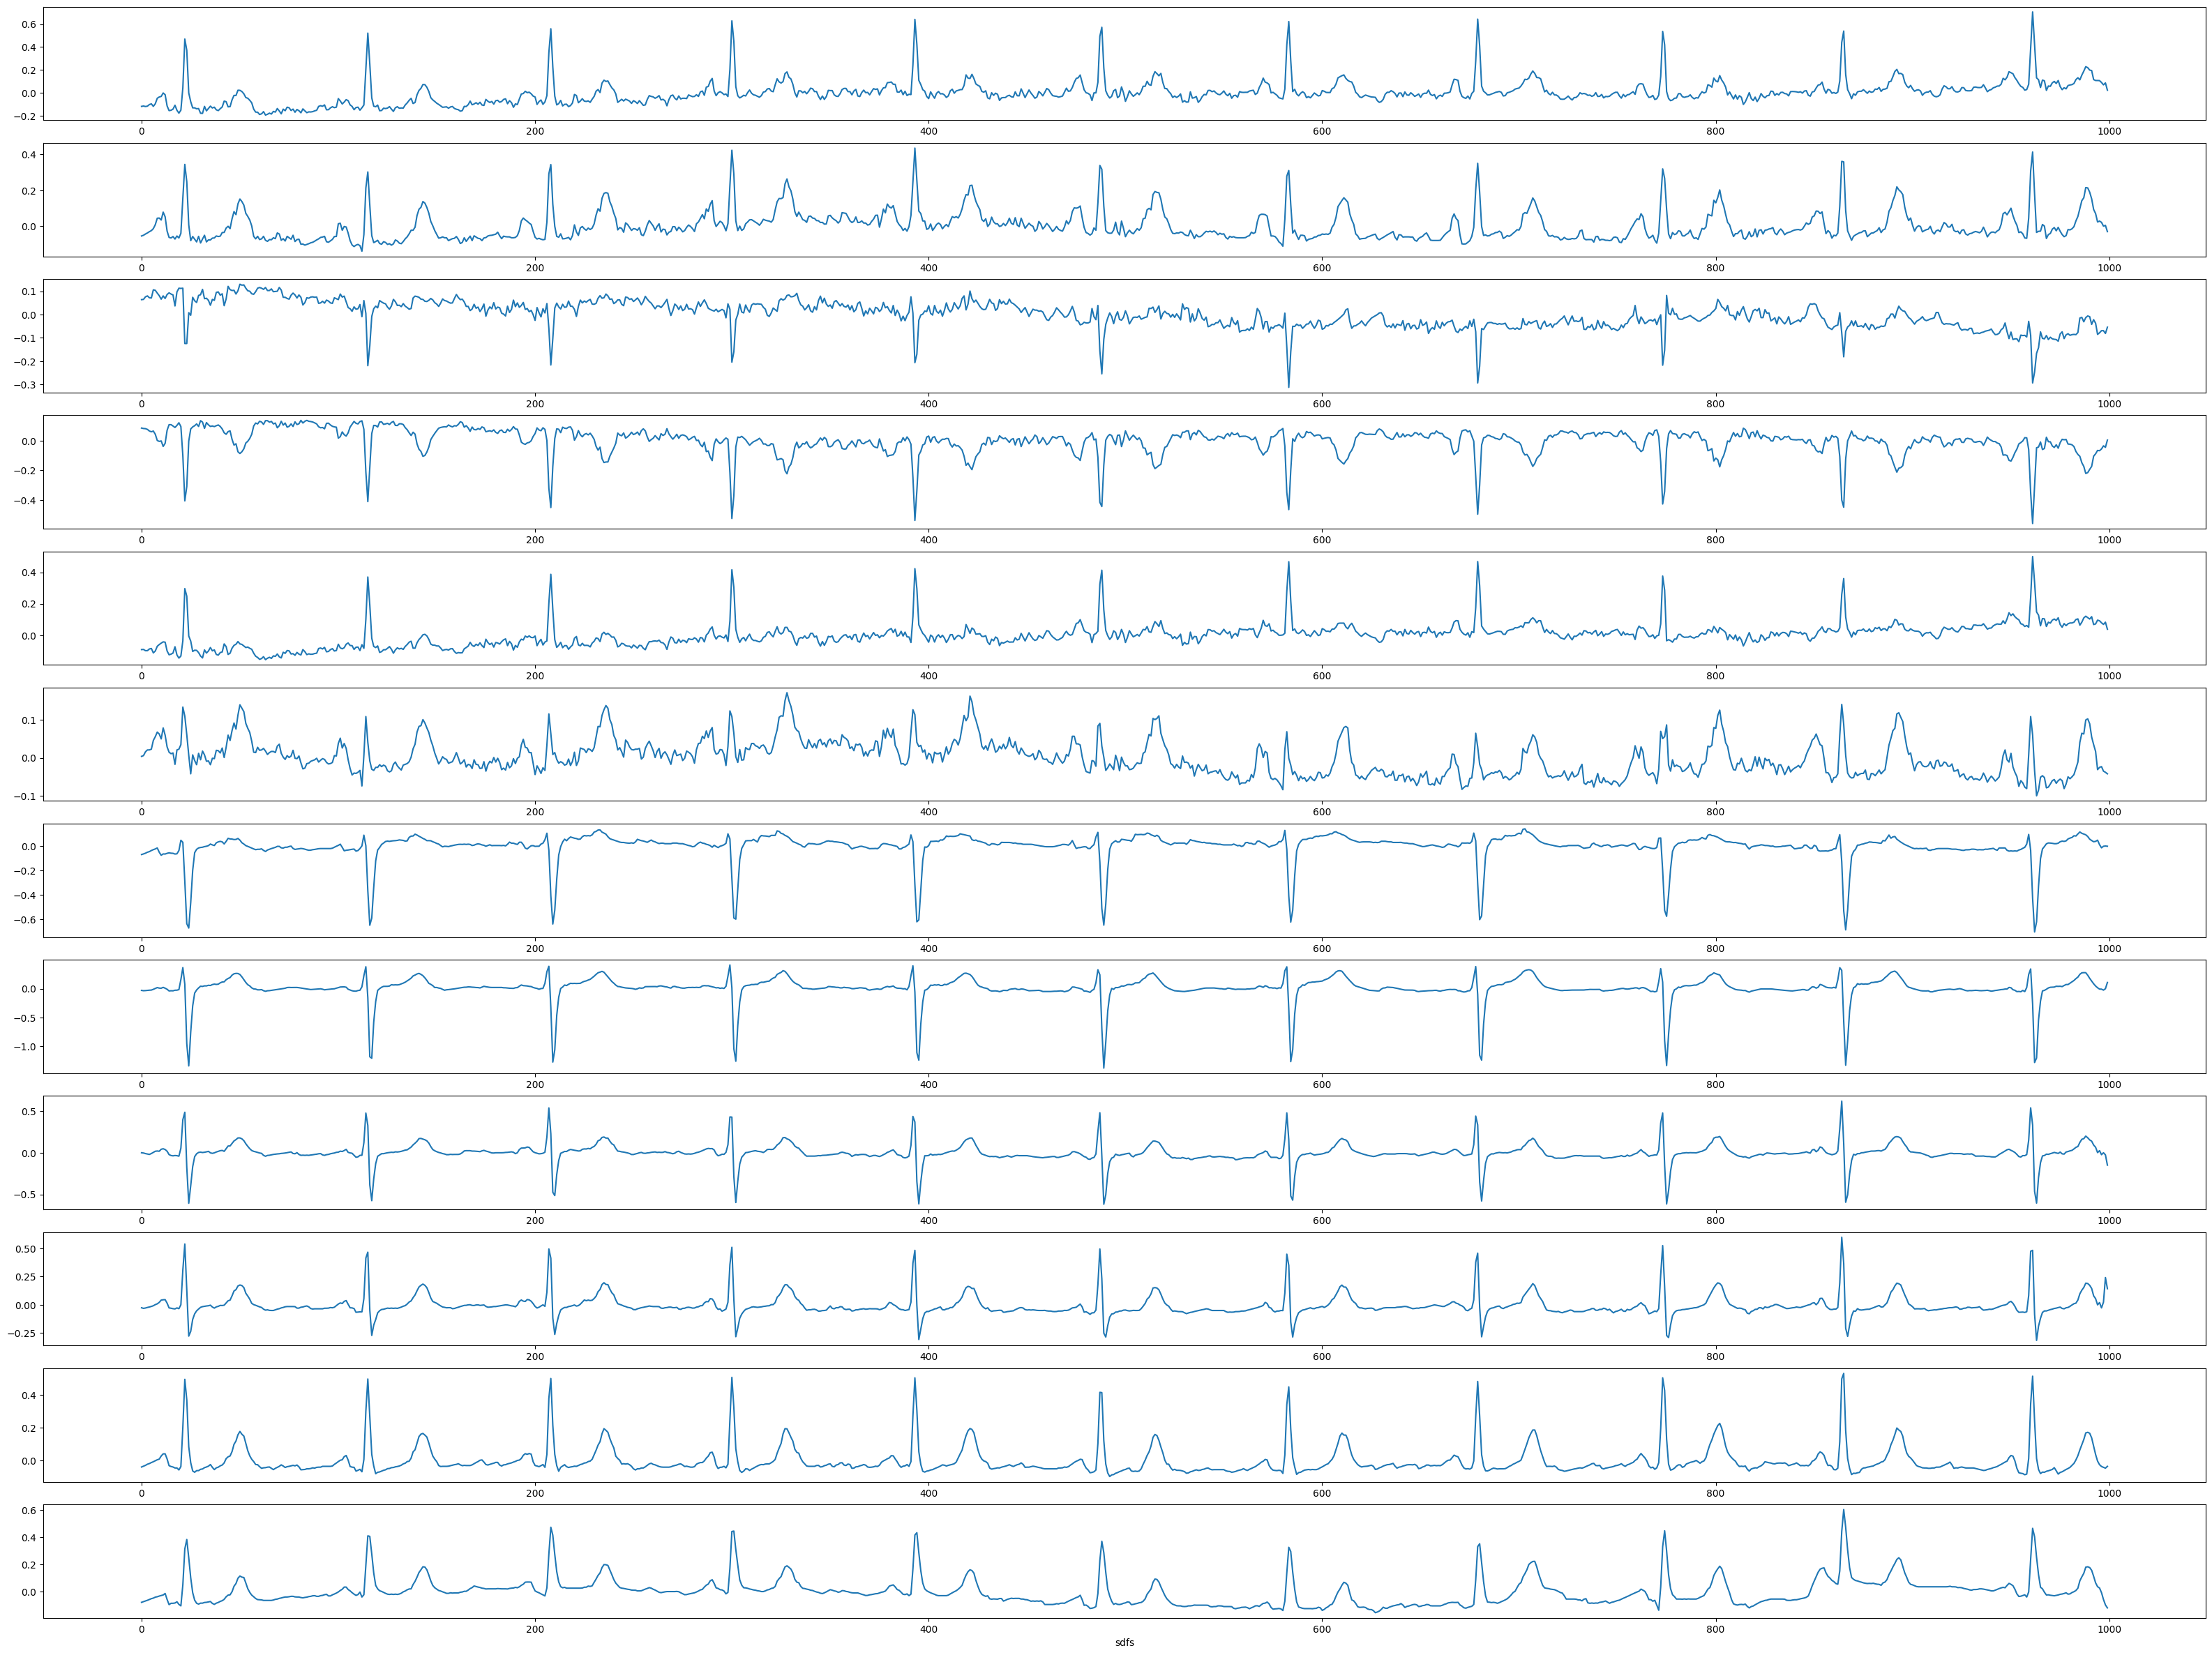

In [ ]:
## ECG data display
import seaborn as sns
sample = X[0]
bar, axes = plt.subplots(sample.shape[1], 1, figsize=(40,30))
for i in range(sample.shape[1]):
    sns.lineplot(x=np.arange(sample.shape[0]), y=sample[:, i], ax=axes[i])
plt.title("real Data")
plt.show()

<Axes: >

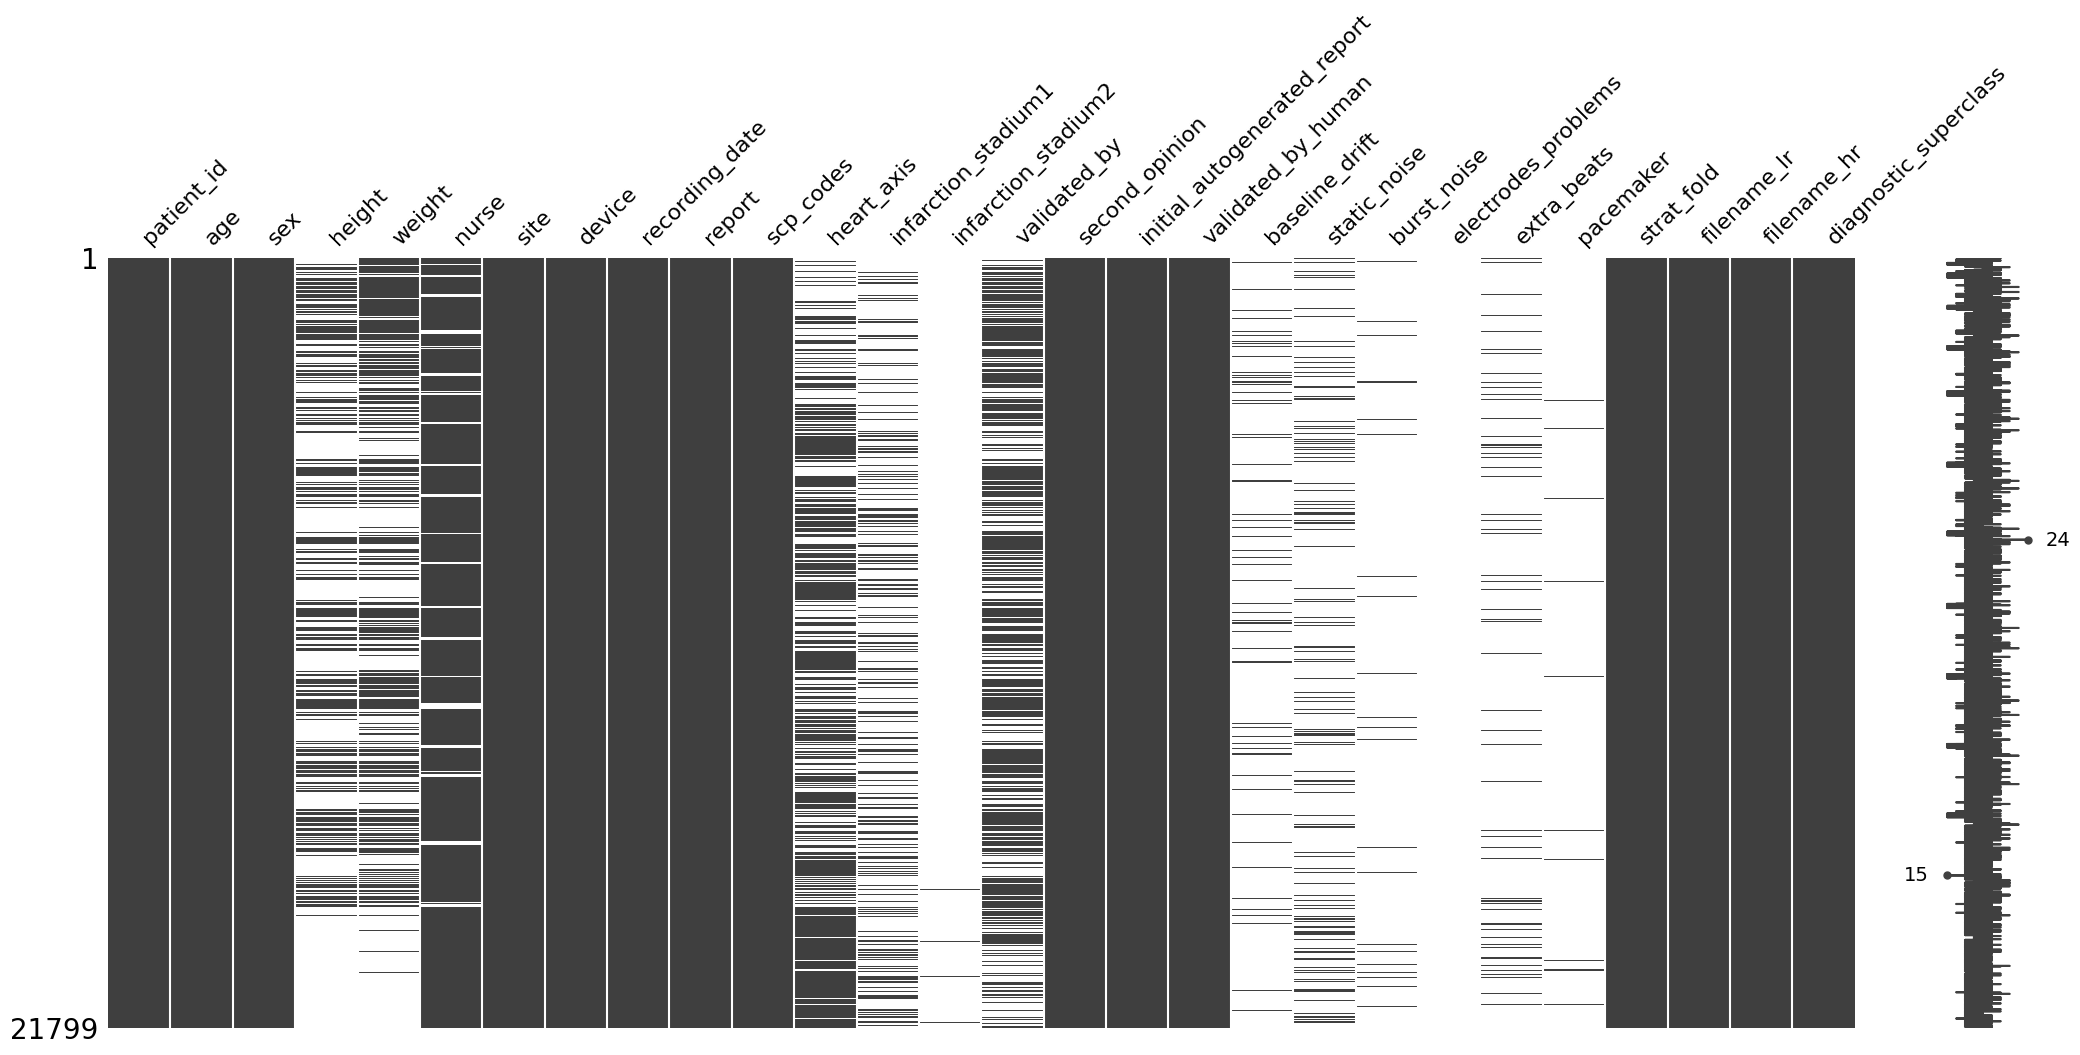

In [52]:
# %pip install missingno
import missingno as msno 
msno.matrix(Y)

In [8]:
from tensorflow.keras.utils import to_categorical

## Seprating super class(5) and subclass

mask = Y['diagnostic_superclass'].apply(lambda x: len(x) == 1)

Y_filtered = Y[mask]
Y_filtered['diagnostic_superclass'] = Y_filtered['diagnostic_superclass'].apply(lambda x: x[0])

dic = {"NORM":0,"MI":1,"STTC":2,"CD":3,"HYP":4}
Y_filtered['diagnostic_superclass'] = Y_filtered['diagnostic_superclass'].map(dic)

Y_filtered_np = np.array(Y_filtered['diagnostic_superclass'])

X_filtered = X[mask]
print(f"new X data size after masking {X_filtered.shape}")


## removing the  reshaping of data
X_reshape = np.reshape(X_filtered,(16244*1000,12))
test_fold = 10
val_fold = 9

print(f"new X data size after Reshaping {X_reshape.shape}")
print(f'size of masked y data {Y_filtered_np.shape}')
# # Train
X_train = X_reshape[np.where((Y_filtered.strat_fold != test_fold)  & (Y_filtered.strat_fold != val_fold))]
y_train = Y_filtered_np[((Y_filtered.strat_fold != test_fold) & (Y_filtered.strat_fold != val_fold))]
# Test
X_test = X_reshape[np.where(Y_filtered.strat_fold == test_fold)]
y_test = Y_filtered_np[(Y_filtered.strat_fold == test_fold)]
X_val = X_reshape[np.where((Y_filtered.strat_fold == val_fold) )]
y_val = Y_filtered_np[(Y_filtered.strat_fold == val_fold)]

from sklearn.preprocessing import StandardScaler
X_scaler = StandardScaler()
X_scaler.fit(X_train)
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)
X_val = X_scaler.transform(X_val)


# from tensorflow.keras.utils import to_categorical
# y_train = to_categorical(y_train,num_classes=5)
# y_test = to_categorical(y_test,num_classes=5)
# y_val = to_categorical(y_val,num_classes=5)

np.save("./artifacts/data_transformation/data_split/ml_model/X_train.npy",X_train)
np.save("./artifacts/data_transformation/data_split/ml_model/X_test.npy",X_test)
np.save("./artifacts/data_transformation/data_split/ml_model/X_val.npy",X_val)
np.save("./artifacts/data_transformation/data_split/ml_model/y_train.npy",y_train)
np.save("./artifacts/data_transformation/data_split/ml_model/y_test.npy",y_test)
np.save("./artifacts/data_transformation/data_split/ml_model/y_val.npy",y_val)

print(f"y_train shape {y_train.shape}, X_train shape {X_train.shape}")
print(f"y_test shape {y_test.shape}, X_test shape {X_test.shape}")
print(f"y_val shape {y_val.shape}, X_val shape {X_val.shape}")









# # X_reshape = np.reshape(X_filtered,(16244*1000,12))
# test_fold = 10
# val_fold = 9

# print(f"new X data size after Reshaping {X_filtered.shape}")
# X_train = X_filtered[np.where((Y_filtered.strat_fold != test_fold)  & (Y_filtered.strat_fold != val_fold))]
# y_train = Y_filtered_np[((Y_filtered.strat_fold != test_fold) & (Y_filtered.strat_fold != val_fold))]
# # Test
# X_test = X_filtered[np.where(Y_filtered.strat_fold == test_fold)]
# y_test = Y_filtered_np[(Y_filtered.strat_fold == test_fold)]
# X_val = X_filtered[np.where((Y_filtered.strat_fold == val_fold) )]
# y_val = Y_filtered_np[(Y_filtered.strat_fold == val_fold)]


# y_train = to_categorical(y_train,num_classes=5)
# y_test = to_categorical(y_test,num_classes=5)
# y_val = to_categorical(y_val,num_classes=5)

# np.save("./artifacts/data_transformation/data_split/dl_model/X_train.npy",X_train)
# np.save("./artifacts/data_transformation/data_split/dl_model/X_test.npy",X_test)
# np.save("./artifacts/data_transformation/data_split/dl_model/X_val.npy",X_val)
# np.save("./artifacts/data_transformation/data_split/dl_model/y_train.npy",y_train)
# np.save("./artifacts/data_transformation/data_split/dl_model/y_test.npy",y_test)
# np.save("./artifacts/data_transformation/data_split/dl_model/y_val.npy",y_val)

# print(f"y_train shape {y_train.shape}, X_train shape {X_train.shape}")
# print(f"y_test shape {y_test.shape}, X_test shape {X_test.shape}")
# print(f"y_val shape {y_val.shape}, X_val shape {X_val.shape}")

# # 12957+1650+1637 = 16,244
# # total = 21799 - 16,244 => 5,555

C:\Users\Ukant\AppData\Local\Temp\ipykernel_5788\259925253.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_filtered['diagnostic_superclass'] = Y_filtered['diagnostic_superclass'].apply(lambda x: x[0])
C:\Users\Ukant\AppData\Local\Temp\ipykernel_5788\259925253.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_filtered['diagnostic_superclass'] = Y_filtered['diagnostic_superclass'].map(dic)


new X data size after masking (16244, 1000, 12)
new X data size after Reshaping (16244000, 12)
size of masked y data (16244,)
y_train shape (12957,), X_train shape (12957, 12)
y_test shape (1650,), X_test shape (1650, 12)
y_val shape (1637,), X_val shape (1637, 12)


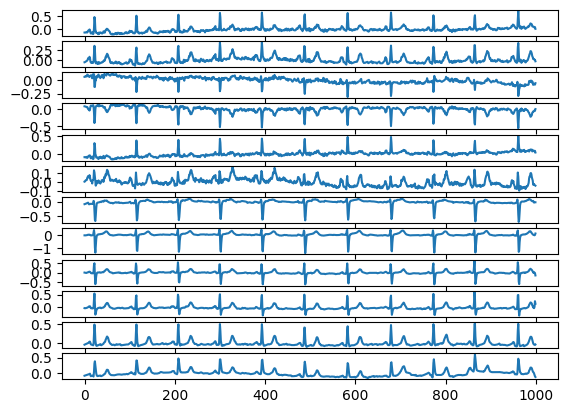

In [8]:
import wfdb
from wfdb import processing
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
files = pd.read_csv(os.path.join(data_path,'ptbxl_database.csv'), index_col='ecg_id')
# bar, axes = plt.subplots(sample.shape[1], 1, figsize=(40,30))
# for i in range(sample.shape[1]):
#     sns.lineplot(x=np.arange(sample.shape[0]), y=sample[:, i], ax=axes[i])

sig, fields = wfdb.rdsamp(os.path.join(data_path,files['filename_lr'].iloc[0]))
bar,axes = plt.subplots(sig.shape[1],1)
for i in range(sig.shape[1]):
    sns.lineplot(x=np.arange(sig.shape[0]), y=sig[:,i], ax=axes[i])
# sns.lineplot(x=np.arange(sample.shape[0]), y=sample[:, i], ax=axes[i])

In [52]:
ann = wfdb.rdann('00001_lr','hea',pn_dir='ptb-xl/1.0.3/records100/00000/')
# https://physionet.org/files/ptb-xl/1.0.3/records100/00000/00001_lr.hea

In [55]:
new_sig, new_ann = processing.resample_singlechan(sig[:, 0], ann, fields['fs'], 100)

In [57]:
ann.symbol[:10],new_ann.symbol[:10]

(['/', '/', '=', '+', '/', 'A', '/', 'A', '/', '/'],
 ['/', '/', '=', '+', '/', 'A', '/', 'A', '/', '/'])

<Axes: ylabel='Count'>

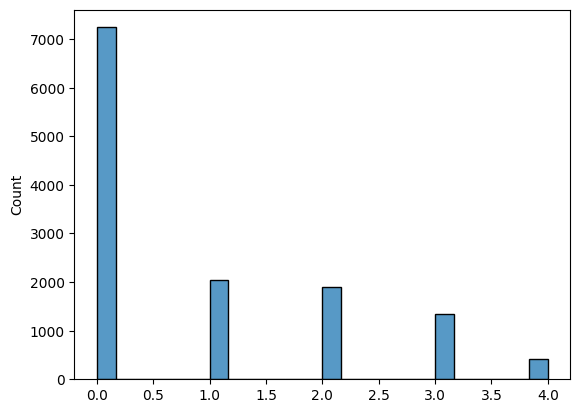

In [17]:
import seaborn as sns
sns.histplot(y_train,)

In [ ]:
scp_df = pd.read_csv(os.path.join(data_path,"scp_statements.csv"),index_col=0)
scp_df.sample(3)

In [119]:
uni_dis = scp_df['description'].value_counts(ascending=True)
unic_class = scp_df.index
unic_statement_des = scp_df['SCP-ECG Statement Description'].value_counts(ascending=False)

In [120]:
unic_statement_des

SCP-ECG Statement Description
in inferior leads                                         2
in anteroseptal leads                                     2
in anterolateral leads                                    2
in inferolateral leads                                    2
in lateral leads                                          2
                                                         ..
Wolff-Parkinson-White syndrome                            1
incomplete left bundle branch block                       1
inferoposterolateral myocardial infarction                1
non-specific ST changes                                   1
trigeminal pattern (unknown origin, SV or Ventricular)    1
Name: count, Length: 66, dtype: int64

In [122]:
unic_class

Index(['NDT', 'NST_', 'DIG', 'LNGQT', 'NORM', 'IMI', 'ASMI', 'LVH', 'LAFB',
       'ISC_', 'IRBBB', '1AVB', 'IVCD', 'ISCAL', 'CRBBB', 'CLBBB', 'ILMI',
       'LAO/LAE', 'AMI', 'ALMI', 'ISCIN', 'INJAS', 'LMI', 'ISCIL', 'LPFB',
       'ISCAS', 'INJAL', 'ISCLA', 'RVH', 'ANEUR', 'RAO/RAE', 'EL', 'WPW',
       'ILBBB', 'IPLMI', 'ISCAN', 'IPMI', 'SEHYP', 'INJIN', 'INJLA', 'PMI',
       '3AVB', 'INJIL', '2AVB', 'ABQRS', 'PVC', 'STD_', 'VCLVH', 'QWAVE',
       'LOWT', 'NT_', 'PAC', 'LPR', 'INVT', 'LVOLT', 'HVOLT', 'TAB_', 'STE_',
       'PRC(S)', 'SR', 'AFIB', 'STACH', 'SARRH', 'SBRAD', 'PACE', 'SVARR',
       'BIGU', 'AFLT', 'SVTAC', 'PSVT', 'TRIGU'],
      dtype='object')

In [117]:
# np.save("./artifacts/data transformation/numpy_data/X_train.npy",X_train)
# np.save("./artifacts/data transformation/numpy_data/X_test.npy",X_test)
# np.save("./artifacts/data transformation/numpy_data/y_train.npy",y_train)
# np.save("./artifacts/data transformation/numpy_data/y_test.npy",y_test)